In [2]:
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt

In [3]:
path = '/content/drive/My Drive/EspecializacionUBA/Matematica/FiltrodeKalman/'

In [4]:
pos = pd.read_csv(path+'posicion.dat',sep="\s+",names=['t','x','y','z'])
vel = pd.read_csv(path+'velocidad.dat',sep="\s+",names=['t','x_','y_','z_'])
acc = pd.read_csv(path+'aceleracion.dat',sep="\s+",names=['t','x__','y__','z__'])

In [5]:
vehiculo = pd.concat([pos,vel[['x_','y_','z_']],acc[['x__','y__','z__']]],join='inner',axis=1)

In [6]:
#pos_ = np.genfromtxt(path+'posicion.dat',dtype=[('t', 'float'), ('x', 'float'), ('y', 'float'),('z', 'float')])
#vel_ = np.genfromtxt(path+'velocidad.dat',dtype=[('t', 'float'), ('x', 'float'), ('y', 'float'),('z', 'float')])
#acc_ = np.genfromtxt(path+'aceleracion.dat',dtype=[('t', 'float'), ('x', 'float'), ('y', 'float'),('z', 'float')])

# Matrices necesarias para el algoritmo

In [7]:
# Creo el data set de predicciones con la posición inicial dada
predicciones_0_0 = pd.DataFrame({'x':[10.7533],'y':[36.6777],'z':[-45.1769],
                             'x_':[1.1009],'y_':[-17.0],'z_':[35.7418],
                             'x__':[-5.7247],'y__':[3.4268],'z__':[5.2774]})

In [8]:
#Matriz de covarianza de la posición inicial
P_0_0 = np.diag(v=[100, 100, 100, 1, 1, 1, 0.01, 0.01, 0.01],k=0)

In [9]:
Q =  np.eye(N=9,M=9) * 0.3

In [10]:
# Creo el data set de predicciones con la posición inicial dada
predicciones_0_0 = pd.DataFrame({'x':[10.7533],'y':[36.6777],'z':[-45.1769],
                             'x_':[1.1009],'y_':[-17.0],'z_':[35.7418],
                             'x__':[-5.7247],'y__':[3.4268],'z__':[5.2774]})

In [11]:
dT = 1 #Delta de tiempo medido
# Filas de la matriz de la dinámica del sistema
p_row = np.hstack( (np.eye(N=3,M=3),np.eye(N=3,M=3)* dT, np.eye(N=3,M=3)* (dT**2)/2) ) #Posición
v_row = np.hstack( (np.zeros(shape=(3,3)),np.eye(N=3,M=3), np.eye(N=3,M=3)* dT) ) #Velocidad
a_row = np.hstack( (np.zeros(shape=(3,3)),np.zeros(shape=(3,3)), np.eye(N=3,M=3)) ) # Aceleración

A = np.vstack((p_row,v_row,a_row)) # Matriz con la dinámica del sistema

In [12]:
# C cuando medimos solo posición
C_pos = np.hstack( (np.eye(N=3,M=3),np.zeros(shape=(3,3)), np.zeros(shape=(3,3))))

# Situacion 1: Ruido Gaussiano en la posicion

In [13]:
len(pos)

351

In [19]:
ruido_normal = np.random.normal(loc=0,scale=100,size=(351,3))
# Posicion con primeros 5 valores con ruido gaussiano
pos_gauss = pos.copy()
pos_gauss.iloc[:,1:4] = pos_gauss.iloc[:,1:4] + ruido_normal#+ 11

In [20]:
R_gauss = np.eye(N=3,M=3) *100

In [21]:
arranque = np.array(predicciones_0_0.iloc[0,:])

In [22]:
# Creo el data set de predicciones con la posición inicial dada
predicciones_0_0 = pd.DataFrame({'x':[10.7533],'y':[36.6777],'z':[-45.1769],
                             'x_':[1.1009],'y_':[-17.0],'z_':[35.7418],
                             'x__':[-5.7247],'y__':[3.4268],'z__':[5.2774]})

In [17]:
def Kalman(Xinic, Pinic, mediciones, A, C, Q, R, posicion=1,velocidad=0,aceleracion=0):
  #Holders
  base_register  = pd.DataFrame({'x':[],'y':[],'z':[],
                             'x_':[],'y_':[],'z_':[],
                             'x__':[],'y__':[],'z__':[]})
  #Xn1_n1 = base_register.copy()
  Xn_n1  = base_register.copy()
  Xn_n = base_register.copy()

  #Pn1_n1 = np.zeros(shape=(1,9,9))
  Pn_n1 = np.zeros(shape=(1,9,9))
  Pn_n = np.zeros(shape=(1,9,9))

  R_size = R.shape[0]
  Kn = np.zeros(shape=(1,9,R_size))

  #Inicializo parámetros
  Xn_n.loc[0] = Xinic
  Pn_n = Pinic.reshape((1,9,9))

  #Algoritmo
  times = len(mediciones)
  for m in range(0,times):
    Xn_n1.loc[m] = A @ Xn_n.loc[m]
    
    Pn_n1 = np.append(Pn_n1, (A @ Pn_n[m] @ A.T + Q).reshape((1,9,9)) ,axis=0) # B Q B pero B es la identidad en este caso, así que la omitimos
    
    Kn =  np.append(Kn, (Pn_n1[m+1] @ C.T @ np.linalg.inv(C@Pn_n1[m+1]@C.T + R)).reshape(1,9,R_size),axis=0 )
    
    #Permite predecir Posición siempre +Velocidad y +Aceleración (pero por ahora no permite solo Velocidad, o solo aceleración,
    # esta implementado de manera "contenida")
    Xn_n.loc[m+1] = Xn_n1.loc[m] + Kn[m+1] @ (mediciones.iloc[m,1:1+3*(posicion+velocidad+aceleracion)] - C @ Xn_n1.loc[m])
    
    Pn_n = np.append(Pn_n, ((np.eye(N=9,M=9) - Kn[m+1] @ C) @ Pn_n1[m+1]).reshape((1,9,9)),axis=0)
  
  return Xn_n



In [42]:
Pred_Gauss = Kalman(arranque, P_0_0,  pos_gauss, A, C_pos, Q, R_gauss,posicion=1,velocidad=0,aceleracion=0)

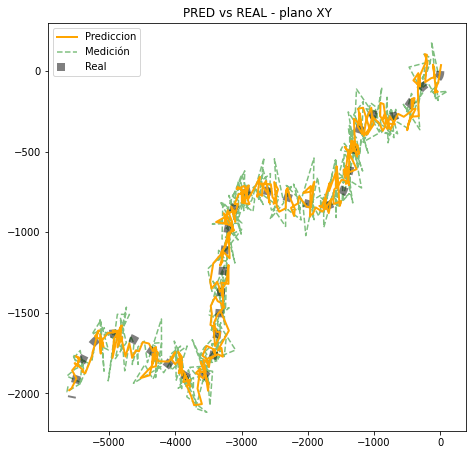

In [97]:
f, ax= plt.subplots(figsize=(7.5,7.5))

ax.plot(Pred_Gauss.x,Pred_Gauss.y,color='orange',label='Prediccion',zorder=3,lw=2)

ax.plot(pos_gauss.x,pos_gauss.y,color='green',ls='--',alpha=0.5,label='Medición',zorder=1)

ax.plot(vehiculo.x,vehiculo.y,color='black',ls=':',alpha=0.5,label='Real',lw=8,zorder=2)

ax.legend()

ax.set_title('PRED vs REAL - plano XY')
plt.show()

In [108]:
import plotly.express as px
import plotly.graph_objects as go
f = go.Figure()
#fig = px.scatter_3d(a, x='x', y='y', z='z')
f = px.scatter_3d(pos_gauss,'x','y','z')

f.show()

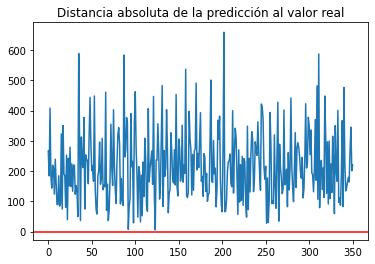

In [47]:
error = np.sqrt((Pred_Gauss.x-pos_gauss.x)**2 + (Pred_Gauss.z-pos_gauss.z)**2+ (Pred_Gauss.z-pos_gauss.z)**2 )
error = error.fillna(0)
distancia_promedio = error.sum()/len(error-1)

f, ax = plt.subplots()
ax.plot(error[:-1])
ax.axhline(y=0,color='red')
ax.set_title('Distancia absoluta de la predicción al valor real')
plt.show()

# Situación 2: Ruido uniforme en la posición

In [39]:
# Si el desvio es de 10 en una uniforme, hay que calcular el máximo, asumiendo que el minimo es en 0
# ver formula de varianza y queda como acá
ruido_uniforme = np.random.uniform(low=0,high=10*np.sqrt(12),size=(351,3))
# Posicion con primeros 5 valores con ruido gaussiano
pos_uni = pos.copy()
pos_uni.iloc[:,1:4] = pos_uni.iloc[:,1:4] + ruido_uniforme#+ 11

In [40]:
# Actualizar la matriz R 
R_uni = np.eye(N=3,M=3) * 10*np.sqrt(12)

In [41]:
pred_uni = Kalman(arranque, P_0_0,  pos_uni, A, C_pos, Q, R_uni,posicion=1,velocidad=0,aceleracion=0)

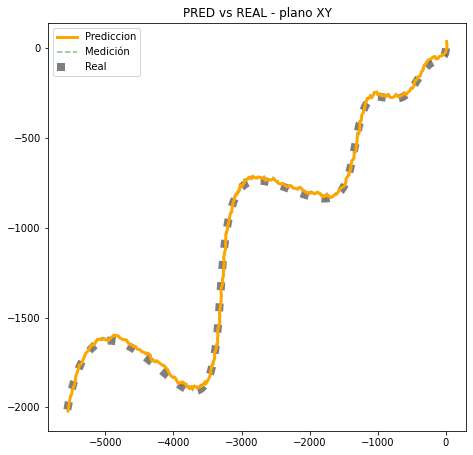

In [94]:
f, ax= plt.subplots(figsize=(7.5,7.5))

ax.plot(pred_uni.x,pred_uni.y,color='orange',label='Prediccion',zorder=3,lw=3)

ax.plot(pos_uni.x,pos_uni.y,color='green',ls='--',alpha=0.5,label='Medición',zorder=1)

ax.plot(vehiculo.x,vehiculo.y,color='black',ls=':',alpha=0.5,label='Real',lw=8,zorder=2)

ax.legend()

ax.set_title('PRED vs REAL - plano XY')
plt.show()

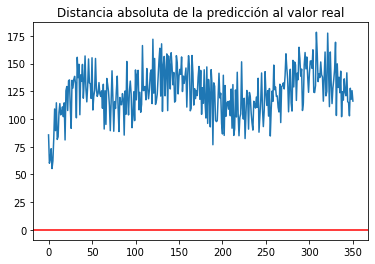

In [46]:
error = np.sqrt((pred_uni.x-pos_uni.x)**2 + (pred_uni.z-pos_uni.z)**2+ (pred_uni.z-pos_uni.z)**2 )
error = error.fillna(0)
distancia_promedio = error.sum()/len(error-1)

f, ax = plt.subplots()
ax.plot(error[:-1])
ax.axhline(y=0,color='red')
ax.set_title('Distancia absoluta de la predicción al valor real')
plt.show()

# Situación 3: Ruido Gaussiano en posición y velocidad

Se mide la posici ́on y la velocidad afectadas por ruido blanco (gaussiano) de 10m
y 0.2m/s de desv ́ıos respectivamente. Analizar si ejora la estimaci ́on.

In [79]:
# Si el desvio es de 10 en una uniforme, hay que calcular el máximo, asumiendo que el minimo es en 0
# ver formula de varianza y queda como acá
ruido_posicion = np.random.normal(loc=0,scale=100,size=(351,3)) # ruido posicion
ruido_velocidad = np.random.normal(loc=0,scale=0.2**2,size=(351,3))
# Posicion con primeros 5 valores con ruido gaussiano
med_pos_vel = vehiculo.iloc[:,:7].copy()
med_pos_vel.iloc[:,1:4] = med_pos_vel.iloc[:,1:4] + ruido_posicion#+ 11
med_pos_vel.iloc[:,4:7] = med_pos_vel.iloc[:,4:7] + ruido_velocidad#+ 11

In [80]:
# C cuando medimos solo posición y velocidad
C_pos = np.hstack( (np.eye(N=3,M=3),np.zeros(shape=(3,3)), np.zeros(shape=(3,3))))
C_vel = np.hstack( (np.zeros(shape=(3,3)) ,np.eye(N=3,M=3), np.zeros(shape=(3,3))))
C_pos_vel = np.vstack((C_pos,C_vel))

In [81]:
prows= np.hstack( (np.eye(N=3,M=3) * 100, np.zeros(shape=(3,3))) )
vrows= np.hstack( ( np.zeros(shape=(3,3)), np.eye(N=3,M=3) * 0.04 ))
R_pos_vel = np.vstack((prows,vrows))

In [82]:
pred_pos_vel = Kalman(Xinic=arranque, Pinic=P_0_0, mediciones= med_pos_vel,
                      A=A, C=C_pos_vel,
                      Q= Q, R= R_pos_vel,
                       posicion=1,velocidad=1,aceleracion=0)

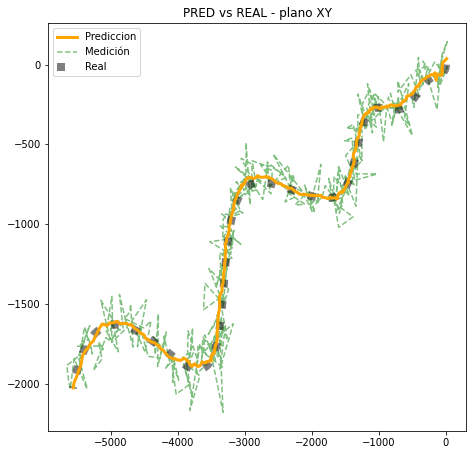

In [93]:
f, ax= plt.subplots(figsize=(7.5,7.5))

ax.plot(pred_pos_vel.x,pred_pos_vel.y,color='orange',label='Prediccion',zorder=3,lw=3)

ax.plot(med_pos_vel.x,med_pos_vel.y,color='green',ls='--',alpha=0.5,label='Medición',zorder=1)

ax.plot(vehiculo.x,vehiculo.y,color='black',ls=':',alpha=0.5,label='Real',lw=8,zorder=2)

ax.legend()

ax.set_title('PRED vs REAL - plano XY')
plt.show()

Text(0.5, 1.0, 'Velocidad_Z')

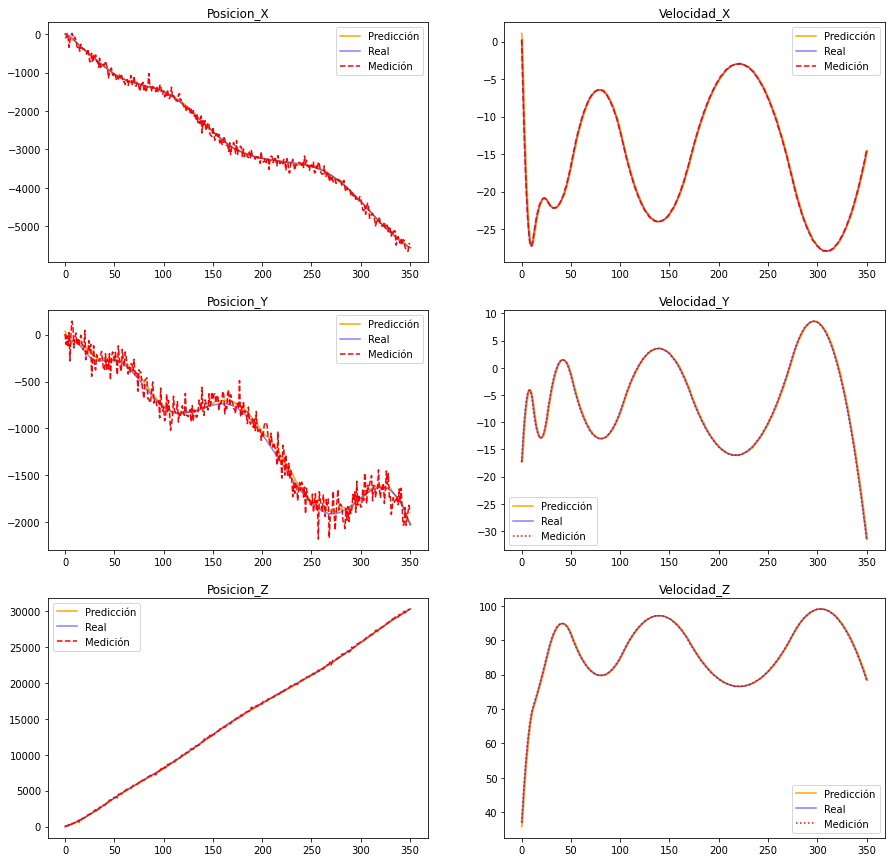

In [84]:
f, ax = plt.subplots(nrows=3,ncols=2,figsize=(15,15))
ax11, ax12,ax21,ax22,ax31,ax32 = ax.flatten()


ax11.plot(pred_pos_vel.x,color='orange',label='Predicción')
ax11.plot(vehiculo.x,color='blue',label='Real',alpha=0.5)
ax11.plot(med_pos_vel.x,color='red',label='Medición',ls='--')
ax11.legend()
ax11.set_title('Posicion_X')

ax12.plot(pred_pos_vel.x_,color='orange',label='Predicción')
ax12.plot(vehiculo.x_,color='blue',label='Real',alpha=0.5)
ax12.plot(med_pos_vel.x_,color='red',label='Medición',ls='--')
ax12.legend()
ax12.set_title('Velocidad_X')

ax21.plot(pred_pos_vel.y,color='orange',label='Predicción')
ax21.plot(vehiculo.y,color='blue',label='Real',alpha=0.5)
ax21.plot(med_pos_vel.y,color='red',label='Medición',ls='--')
ax21.legend()
ax21.set_title('Posicion_Y')

ax22.plot(pred_pos_vel.y_,color='orange',label='Predicción')
ax22.plot(vehiculo.y_,color='blue',label='Real',alpha=0.5)
ax22.plot(med_pos_vel.y_,color='red',label='Medición',ls=':')
ax22.legend()
ax22.set_title('Velocidad_Y')

ax31.plot(pred_pos_vel.z,color='orange',label='Predicción')
ax31.plot(vehiculo.z,color='blue',label='Real',alpha=0.5)
ax31.plot(med_pos_vel.z,color='red',label='Medición',ls='--')
ax31.legend()
ax31.set_title('Posicion_Z')

ax32.plot(pred_pos_vel.z_,color='orange',label='Predicción')
ax32.plot(vehiculo.z_,color='blue',label='Real',alpha=0.5)
ax32.plot(med_pos_vel.z_,color='red',label='Medición',ls=':')
ax32.legend()
ax32.set_title('Velocidad_Z')
